# Image Generation Agent with Cost Approval
The scenario:

Build an agent that generates images using the MCP server, but requires approval for "bulk" image generation:

1. Single image request (1 image): Auto-approve, generate immediately
2. Bulk request (>1 image): Pause and ask for approval before generating multiple images
3. Explore different publicly available Image Generation MCP Servers

In [1]:
# Load API Key
from dotenv import load_dotenv
load_dotenv()

False

# Confirm GOOGLE_API_KEY

In [12]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Setup and authentication complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Setup and authentication complete.


# Import ADK components
Import the specific components you'll need from the Agent Development Kit. This keeps your code organized and ensures we have access to the necessary building blocks.

In [13]:
import uuid
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService

from google.adk.tools.mcp_tool.mcp_toolset import McpToolset
from google.adk.tools.tool_context import ToolContext
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters

from google.adk.apps.app import App, ResumabilityConfig
from google.adk.tools.function_tool import FunctionTool
from google.adk.tools import AgentTool

from google.adk.runners import InMemoryRunner

from IPython.display import display, Image as IPImage
import uuid, random, base64
import re

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


In [87]:
# Removing warnings
import warnings

warnings.filterwarnings(
    "ignore",
    message=".*experimental.*",
    category=UserWarning
)

import logging

logging.getLogger("google_genai").setLevel(logging.ERROR)
logging.getLogger("google_genai.types").setLevel(logging.ERROR)
logging.getLogger("google.adk").setLevel(logging.ERROR)

### Configure Retry Options
When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.

In [14]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

### Define Helper Functions
Helper function to show the Image returned by the LLM in jupyter cell output

In [30]:
def show_image(response, width=200):
    for event in response:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if hasattr(part, "function_response") and part.function_response:
                    for item in part.function_response.response.get("content", []):
                        if item.get("type") == "image":
                            display(IPImage(data=base64.b64decode(item["data"]), width=width))

### Define MCP Servers

In [16]:
# MCP integration with Everything Server
mcp_image_server = McpToolset(
    connection_params=StdioConnectionParams(
        server_params=StdioServerParameters(
            command="npx",  # Run MCP server via npx
            args=[
                "-y",  # Argument for npx to auto-confirm install
                "@modelcontextprotocol/server-everything",
            ],
            tool_filter=["getTinyImage"],
        ),
        timeout=30,
    )
)

print("✅ Small Images MCP Tool created")

✅ Small Images MCP Tool created


Use MCP Server @pollinations/model-context-protocol for image generation

In [17]:
# Setup the MCP toolset pointing to Pollinations server
mcp_image_generation_server = McpToolset(
    connection_params = StdioConnectionParams(
        server_params = StdioServerParameters(
            command = "npx",
            args=[
                "-y",
                "@pollinations/model-context-protocol",
                "serve"  # sometimes required to start the server
            ],
            tool_filter = ["generateImage"],  # filter to the tool you want
        ),
        timeout = 30,
    )
)

print("✅ Image Generateion Pollinations MCP Tool created")

✅ Image Generateion Pollinations MCP Tool created


In [39]:
# To check if server can be reached
# !npm i @pollinations/model-context-protocol
# !npx -y @pollinations/model-context-protocol

⠙Pollinations Multimodal MCP server running on stdio
^C


# 1. Single image request (1 image): Auto-approve, generate immediately

In [18]:
image_generation_agent = LlmAgent(
    name="image_generation_agent",
    model=Gemini(
        model='gemini-2.5-flash-lite', retry_options=retry_config
    ),
    description="Generates a single image using the Image Generation MCP Server",
    instruction="""You are a helpful Image Generation Assistant, your tasks are the following:
    - Generates a single image using the `mcp_image_generation_server` tool of the given user query.
    - If the user query asks for more than 1 image then politely decline.
    - If the user query does not contain the number of images then generate a single image of the query.""",
    tools=[mcp_image_generation_server]
)

In [19]:
# Create a runner
runner = InMemoryRunner(agent=image_generation_agent)

In [129]:
# Test the Agent
response = await runner.run_debug("Generate an Sketch of a cute anime girl with black hair (seed=42)")


 ### Continue session: debug_session_id

User > Generate two Sketches of cute anime girls with black hair (seed=42)
image_generation_agent > I can only generate one image at a time.


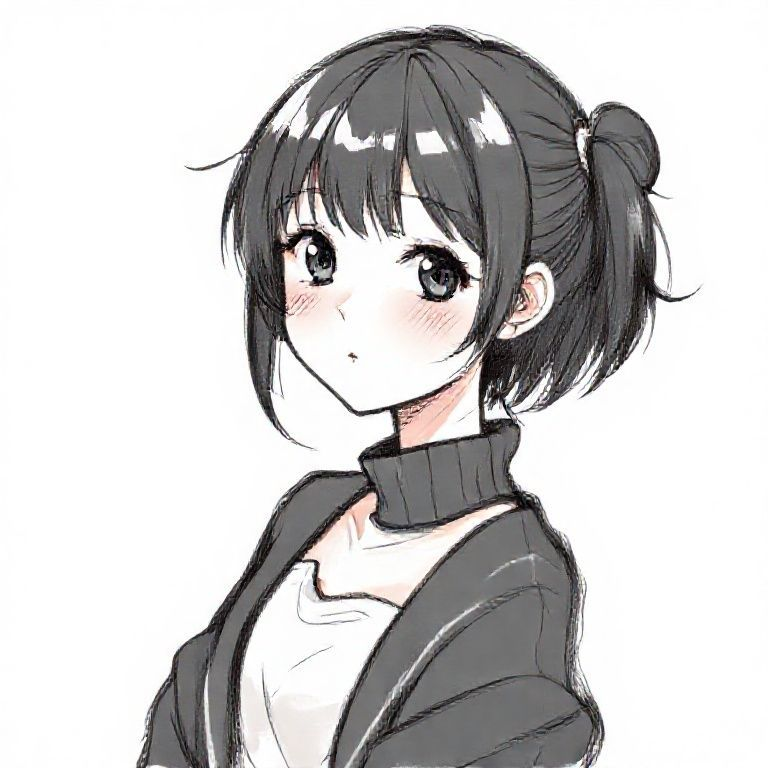

In [36]:
show_image(response, width=300)

# 2. Build an agent that returns tiny images using the MCP server, but requires approval for bulk image generation

The scenario:

Build an agent that returns tiny images using the MCP server, but requires approval for "bulk" image generation:

* Single image request (1 image): Auto-approve, return image immediately
* Bulk request (>1 image): Pause and ask for approval before returning multiple images

In [108]:
NUMBER_OF_IMAGES_THRESHOLD = 1

def generate_images(num_images: int, prompt: str, tool_context: ToolContext) -> dict:
    """Generate images. Requires approval if num_images > threshold."""

    # SCENARIO 1: Small orders (≤1 images) auto-approve
    if num_images <= NUMBER_OF_IMAGES_THRESHOLD:
        return {
            "status": "approved",
            "order_id": f"ORD-{num_images}-AUTO",
            "num_images": num_images,
            "prompt": prompt,
            "message": f"Order auto-approved for {num_images} images."
        }
        
    # SCENARIO 2: This is the first time this tool is called. Large orders need human approval - PAUSE here.
    if not tool_context.tool_confirmation:
        tool_context.request_confirmation(
            hint=f"⚠️ Large order: {num_images} to be generated. Do you want to approve?",
            payload={"num_images": num_images, "prompt": prompt}
        )
        return {
            "status": "pending",
            "message": f"Order for {num_images} Images requires approval."
        }
        
    # SCENARIO 3: The tool is called AGAIN and is now resuming. Handle approval response - RESUME here.
    if tool_context.tool_confirmation.confirmed:
        return {
            "status": "approved",
            "order_id": f"ORD-{num_images}-HUMAN",
            "num_images": num_images,
            "prompt": prompt,
            "message": f"Order approved! Now call getTinyImage {num_images} times with prompt: {prompt}"
        }
    else:
        return {
            "status": "rejected",
            "message": "Order rejected."
        }

In [109]:
# Create place order agent with pausable tool
image_gen_agent = LlmAgent(
    name="image_gen_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
        You are an assistant that handles image generation.
        
        ## Workflow:
        1. Use the `generate_images` tool with the number of images and prompt.
        2. If the tool returns "pending", inform the user that approval is required.
        3. If the tool returns "approved":
           - Call the MCP tool `getTinyImage` multiple times (once for each image).
           - The `getTinyImage` tool generates ONE image per call with only a `prompt` parameter.
           - Keep calling until you have generated all requested images.
        4. If "rejected", tell the user the order was denied.
        5. **Always include the order summary at the end.**
        
        ---
        **Order Summary:**
        * **Status:** <approved|pending|rejected>
        * **Order ID:** <order_id or 'N/A'>
        * **Number of Images:** <num_images>
        ---
        
        Never omit this section, even if images were not generated.
        """,
    tools=[
        FunctionTool(func=generate_images),
        mcp_image_server,  # MCP image generator tool
    ],
)

print("✅ Place order Agent created!")

✅ Place order Agent created!


In [110]:
coordinator_app = App(
    name="coordinator_app",
    root_agent = image_gen_agent,
    resumability_config=ResumabilityConfig(is_resumable=True) # Ensures the application resumability after human approval
)

print("✅ Resumable app created!")

✅ Resumable app created!


In [111]:
# Create session
session_service = InMemorySessionService()

# Create runner with the resumable app
generation_runner = Runner(
    app=coordinator_app,  # Pass the app instead of the agent
    session_service=session_service
)

print("✅ Runner created!")

✅ Runner created!


In [135]:
# Create Helper Functions for the app to run and resumability

def check_for_approval(events):
    """Check if events contain an approval request.

    Returns:
        dict with approval details or None
    """
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if (
                    part.function_call
                    and part.function_call.name == "adk_request_confirmation" # The application is asking for human approval
                ):
                    return {
                        "approval_id": part.function_call.id,
                        "invocation_id": event.invocation_id,
                    }
    return None


def print_agent_response(events):
    """Print agent's text responses from events."""
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if part.text:
                    print(f"Agent > {part.text}")


def create_approval_response(approval_info, approved):
    """Create approval response message."""
    confirmation_response = types.FunctionResponse(
        id=approval_info["approval_id"],
        name="adk_request_confirmation",
        response={"confirmed": approved},
    )
    return types.Content(
        role="user", parts=[types.Part(function_response=confirmation_response)]
    )


def show_base64_images(img_list):
    for idx, img_data in enumerate(img_list, start=1):
        print(f"Image {idx}")
        display(IPImage(data=base64.b64decode(img_data)))


print("✅ Helper functions defined")

✅ Helper functions defined


In [ ]:
async def run_generation_workflow(query: str, auto_approve: bool = True):
    """Runs an image generation workflow with approval handling and prompt variation."""
    
    print(f"\n{'='*60}")
    print(f"User > {query}\n")
    
    # Generate unique session ID
    session_id = f"order_{uuid.uuid4().hex[:8]}"
    
    # Create session
    session = await session_service.create_session(
        app_name="coordinator_app", user_id="test_user", session_id=session_id
    )
    
    query_content = types.Content(role="user", parts=[types.Part(text=query)])
    
    events = []
    
    # Step 1 – ask the agent to generate images
    async for event in generation_runner.run_async(
        user_id="test_user", session_id=session_id, new_message=query_content
    ):
        events.append(event)
    
    # check if human approval is needed
    approval_info = check_for_approval(events)
    
    # Step 2 – handle approval path
    if approval_info:
        print("⏸️  Pausing for approval…")
        print(f"🤔 Human Decision: {'APPROVE ✅' if auto_approve else 'REJECT ❌'}\n")
        
        # Resume with approval response
        async for event in generation_runner.run_async(
            user_id="test_user",
            session_id=session_id,
            new_message=create_approval_response(approval_info, auto_approve),
            invocation_id=approval_info["invocation_id"]
        ):
            events.append(event)
            print_agent_response([event])
        
        if not auto_approve:
            print("🚫 Order rejected – no images generated.")
            print(f"{'='*60}\n")
            return
    
    else:  # No approval needed - already generated
        print_agent_response(events)
    
    # The agent should have already called getTinyImage during the run
    # Extract images from the events
    generated_images = []
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if hasattr(part, "function_response") and part.function_response:
                    resp = part.function_response.response
                    if resp and "content" in resp:
                        for item in resp["content"]:
                            if item.get("type") == "image":
                                generated_images.append(item["data"])
    
    # Display images
    print("\n🖼️  Displaying images...")
    show_base64_images(generated_images)

In [123]:
# Demo 1: It's a small order. Agent receives auto-approved status from tool
response = await run_generation_workflow("Provide 1 tiny images.")


User > Provide 1 tiny images.

Agent > Here is your tiny image.

**Order Summary:**
* **Status:** approved
* **Order ID:** ORD-1-AUTO
* **Number of Images:** 1
***
The image above is the MCP tiny image.

🖼️  Displaying images...
Image 1


In [124]:
# Demo 2: Workflow simulates human decision: APPROVE ✅
await run_generation_workflow("Provide 3 tiny images", auto_approve=True)


User > Provide 3 tiny images

⏸️  Pausing for approval…
🤔 Human Decision: APPROVE ✅

Agent > **Order Summary:**
* **Status:** approved
* **Order ID:** ORD-3-HUMAN
* **Number of Images:** 3

🖼️  Displaying images...
Image 1


Image 2


Image 3


# 3. Build an agent that generates images using the MCP server, but requires approval for bulk image generation

The scenario:

Build an agent that generates images using the MCP server, but requires approval for "bulk" image generation:

* Single image request (1 image): Auto-approve, generate immediately
* Bulk request (>1 image): Pause and ask for approval before generating multiple images
* Explore different publicly available Image Generation MCP Servers

In [154]:
NUMBER_OF_IMAGES_THRESHOLD = 1

def generate_images(num_images: int, prompt: str, tool_context: ToolContext) -> dict:
    """Generate images. Requires approval if num_images > threshold."""

    # SCENARIO 1: Small orders (≤1 images) auto-approve
    if num_images <= NUMBER_OF_IMAGES_THRESHOLD:
        return {
            "status": "approved",
            "order_id": f"ORD-{num_images}-AUTO",
            "num_images": num_images,
            "prompt": prompt,
            "message": f"Order auto-approved for {num_images} images."
        }
        
    # SCENARIO 2: This is the first time this tool is called. Large orders need human approval - PAUSE here.
    if not tool_context.tool_confirmation:
        tool_context.request_confirmation(
            hint=f"⚠️ Large order: {num_images} to be generated. Do you want to approve?",
            payload={"num_images": num_images, "prompt": prompt}
        )
        return {
            "status": "pending",
            "message": f"Order for {num_images} Images requires approval."
        }
        
    # SCENARIO 3: The tool is called AGAIN and is now resuming. Handle approval response - RESUME here.
    if tool_context.tool_confirmation.confirmed:
        return {
            "status": "approved",
            "order_id": f"ORD-{num_images}-HUMAN",
            "num_images": num_images,
            "prompt": prompt,
            "message": f"Order approved! Now call `generateImage` {num_images} times with prompt: {prompt}"
        }
    else:
        return {
            "status": "rejected",
            "message": "Order rejected."
        }

In [155]:
# Create place order agent with pausable tool
image_gen_agent = LlmAgent(
    name="image_gen_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
        You are an assistant that handles image generation.
        
        ## Workflow:
        1. Use the `generate_images` tool with the number of images and prompt.
        2. If the tool returns "pending", inform the user that approval is required.
        3. If the tool returns "approved":
           - Call the MCP tool `generateImage` multiple times (once for each image).
           - The `generateImage` tool generates ONE image per call with only a `prompt` parameter.
           - Keep calling until you have generated all requested images.
        4. If "rejected", tell the user the order was denied.
        5. **Always include the order summary at the end.**
        
        ---
        **Order Summary:**
        * **Status:** <approved|pending|rejected>
        * **Order ID:** <order_id or 'N/A'>
        * **Number of Images:** <num_images>
        ---
        
        Never omit this section, even if images were not generated.
        """,
    tools=[
        FunctionTool(func=generate_images),
        mcp_image_generation_server,  # MCP image generator tool
    ],
)

print("✅ Place order Agent created!")

✅ Place order Agent created!


In [156]:
coordinator_app = App(
    name="coordinator_app",
    root_agent = image_gen_agent,
    resumability_config=ResumabilityConfig(is_resumable=True) # Ensures the application resumability after human approval
)

print("✅ Resumable app created!")

✅ Resumable app created!


In [157]:
# Create session
session_service = InMemorySessionService()

# Create runner with the resumable app
generation_runner = Runner(
    app=coordinator_app,  # Pass the app instead of the agent
    session_service=session_service
)

print("✅ Runner created!")

✅ Runner created!


In [158]:
# Create Helper Functions for the app to run and resumability

def check_for_approval(events):
    """Check if events contain an approval request.

    Returns:
        dict with approval details or None
    """
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if (
                    part.function_call
                    and part.function_call.name == "adk_request_confirmation" # The application is asking for human approval
                ):
                    return {
                        "approval_id": part.function_call.id,
                        "invocation_id": event.invocation_id,
                    }
    return None


def print_agent_response(events):
    """Print agent's text responses from events."""
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if part.text:
                    print(f"Agent > {part.text}")


def create_approval_response(approval_info, approved):
    """Create approval response message."""
    confirmation_response = types.FunctionResponse(
        id=approval_info["approval_id"],
        name="adk_request_confirmation",
        response={"confirmed": approved},
    )
    return types.Content(
        role="user", parts=[types.Part(function_response=confirmation_response)]
    )


def show_base64_images(img_list, width=200):
    for idx, img_data in enumerate(img_list, start=1):
        print(f"Image {idx}")
        display(IPImage(data=base64.b64decode(img_data), width=width))


print("✅ Helper functions defined")

✅ Helper functions defined


In [ ]:
async def run_generation_workflow(query: str, auto_approve: bool = True):
    """Runs an image generation workflow with approval handling and prompt variation."""
    
    print(f"\n{'='*60}")
    print(f"User > {query}\n")
    
    # Generate unique session ID
    session_id = f"order_{uuid.uuid4().hex[:8]}"
    
    # Create session
    session = await session_service.create_session(
        app_name="coordinator_app", user_id="test_user", session_id=session_id
    )
    
    query_content = types.Content(role="user", parts=[types.Part(text=query)])
    
    events = []
    
    # Step 1 – ask the agent to generate images
    async for event in generation_runner.run_async(
        user_id="test_user", session_id=session_id, new_message=query_content
    ):
        events.append(event)
    
    # check if human approval is needed
    approval_info = check_for_approval(events)
    
    # Step 2 – handle approval path
    if approval_info:
        print("⏸️ Pausing for approval…")
        print(f"🤔 Human Decision: {'APPROVE ✅' if auto_approve else 'REJECT ❌'}\n")
        
        # Resume with approval response
        async for event in generation_runner.run_async(
            user_id="test_user",
            session_id=session_id,
            new_message=create_approval_response(approval_info, auto_approve),
            invocation_id=approval_info["invocation_id"]
        ):
            events.append(event)
            print_agent_response([event])
        
        if not auto_approve:
            print("🚫 Order rejected – no images generated.")
            print(f"{'='*60}\n")
            return
    
    else:  # No approval needed - already generated
        print_agent_response(events)
    
    # The agent should have already called getTinyImage during the run
    # Extract images from the events
    generated_images = []
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if hasattr(part, "function_response") and part.function_response:
                    resp = part.function_response.response
                    if resp and "content" in resp:
                        for item in resp["content"]:
                            if item.get("type") == "image":
                                generated_images.append(item["data"])
    
    # Display images
    print("\n🖼️  Displaying images...")
    show_base64_images(generated_images)


User > Generate an Sketch of a cute anime girl with black hair (seed=42)

Agent > Here's a sketch of a cute anime girl with black hair! ✨ Let me know if you want any other cool images. 🎨
***
* **Status:** approved
* **Order ID:** N/A
* **Number of Images:** 1

🖼️  Displaying images...
Image 1


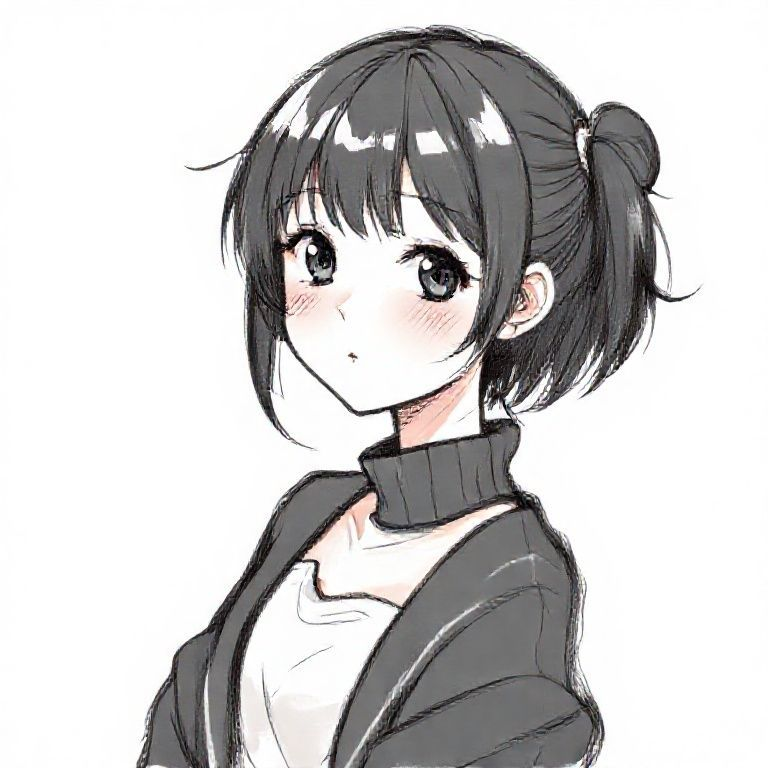

In [160]:
# Demo 1: It's a small order. Agent receives auto-approved status from tool
response = await run_generation_workflow("Generate an Sketch of a cute anime girl with black hair (seed=42)")


User > Generate 3 Sketches of cute anime girl with pink and blue hair everytime (seed=42)

⏸️  Pausing for approval…
🤔 Human Decision: APPROVE ✅

Agent > **Order Summary:**
* **Status:** approved
* **Order ID:** ORD-3-HUMAN
* **Number of Images:** 3

🖼️  Displaying images...
Image 1


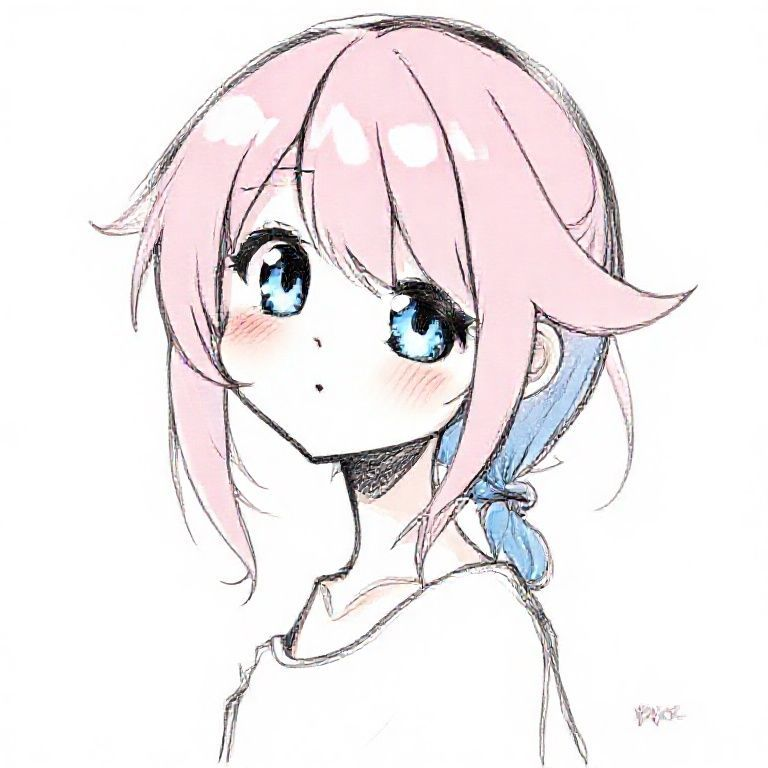

Image 2


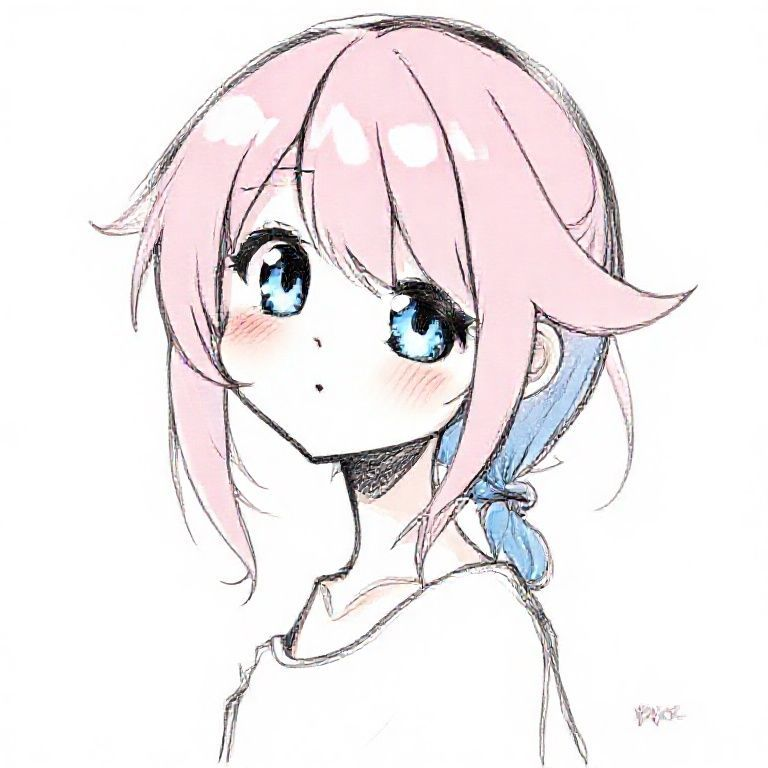

Image 3


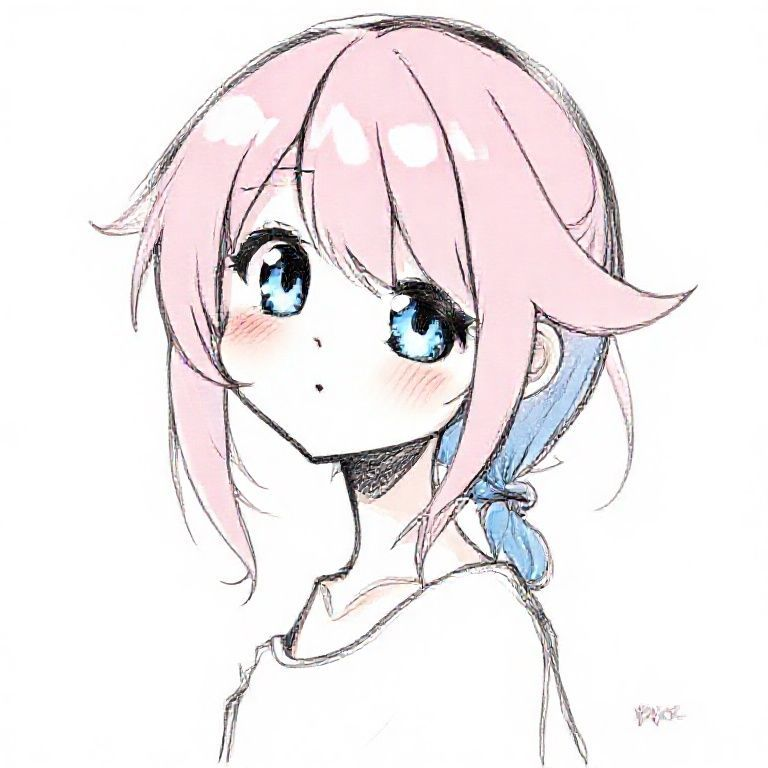

In [161]:
# Demo 2: Workflow simulates human decision: APPROVE ✅
await run_generation_workflow("Generate 3 Sketches of cute anime girl with pink and blue hair everytime (seed=42)", auto_approve=True)